In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

import re

In [3]:
!nvidia-smi

/bin/sh: 1: nvidia-smi: not found


## Input Pipeline

In [13]:
import csv

transcripts = []

with open('datasets/transcripts.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    for i, row in enumerate(reader):
        if not i:
            continue
        transcripts.append(row[0])


In [15]:
print(len(transcripts))

2467


In [33]:
def count_chars(char):
    c = 0
    for tran in transcripts:
         c += tran.count(char)
    return c

In [36]:
count_chars('.')

299645

In [37]:
count_chars('?')

26460

In [38]:
count_chars(',')

354791

In [35]:
count_chars('!')

2339

In [ ]:


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything in between parentheses (audience reactions)
    # Reference: https://stackoverflow.com/questions/14596884/remove-text-between-and-in-python/14598135
    w = re.sub("[\(.*?[\)]", "", w)
    
    
    #
    
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,]+", " ", w)

    
    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    # w = '<start> ' + w + ' <end>'
    return w

## Positional encoding

In [24]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model)) # (1, len(i))
    return pos * angle_rates

In [25]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
    
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


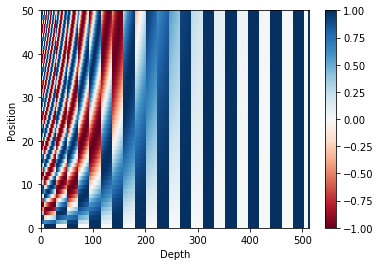

In [26]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)
a = pos_encoding.numpy()

plt.pcolormesh(pos_encoding[0], cmap='RdBu', vmin=-1, vmax=1)

plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Scaled dot product attention

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
        q: query shape == (..., seq_len_q, depth)
        k: key shape == (..., seq_len_k, depth)
        v: value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable 
              to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
        output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  
    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights